# Required imports

In [1]:
import torch
import torchmetrics
import wandb

import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from review_classifier import ReviewClassifier

# Logging into Weights&Biases

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dominika-boguszewska-stud (dominika-boguszewska-stud-warsaw-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Loading data

In [3]:
dataset = load_dataset("Yelp/yelp_review_full")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

## Splitting data into training, validation and testing datasets

In [5]:
test_dataset = dataset["test"]

split_dataset = dataset["train"].train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

In [6]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['label', 'text'],
    num_rows: 520000
})
Dataset({
    features: ['label', 'text'],
    num_rows: 130000
})
Dataset({
    features: ['label', 'text'],
    num_rows: 50000
})


In [7]:
print(train_dataset[0])

{'label': 0, 'text': "Have eaten at a few Brazilian grills in the pat from Albuquerque to Washington DC.  Pampas was definitely not the best. The service was average, but the cleanliness of the restaurant was very poor.  The floor seemed like an oil slick and the walls were splattered with food and drink. Wouldn't recommend.  Disappointment."}


## Creating smaller subsets

In [8]:
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset) * .15)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset) * .1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset) * .4)))

print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")
print(f"Number of samples in testing set: {len(test_dataset)}")

Number of samples in training set: 78000
Number of samples in validation set: 13000
Number of samples in testing set: 20000


## Histogram of labels in training dataset

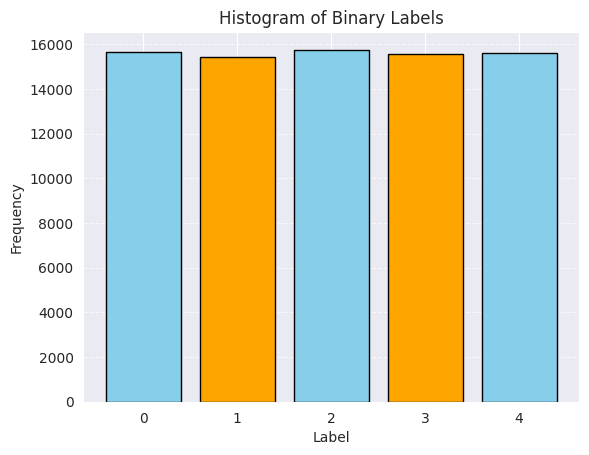

In [9]:
# Count occurrences of each label
unique_labels, counts = np.unique(train_dataset['label'], return_counts=True)

# Plot histogram
plt.bar(unique_labels, counts, color=['skyblue', 'orange'], edgecolor='black')
plt.title('Histogram of Binary Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# TF-IDF Feature Extraction

In [10]:
vocab_size = 10000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    analyzer='word',
    ngram_range=(1, 1),
    stop_words="english"
)

train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

In [11]:
print(f"Size of TF-IDF matrix for training dataset: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Example features: {np.random.choice(feature_names, 20)}\n")

Size of TF-IDF matrix for training dataset: (78000, 10000)
train_tfidf_features.dtype=dtype('float64')

Number of features: 10000
Example features: ['diverse' 'floating' '120' 'flew' 'yells' 'melon' '4pm' 'speakeasy'
 'extensive' 'cover' 'scores' 'custard' 'ca' 'reduction' 'store'
 'similarly' 'emeril' 'runners' 'generally' 'crossing']



## Displaying the feature vector for the selected training set element

In [12]:
ndx = 111
print(f"Training set element with index={ndx}")
print(f"{train_dataset['text'][ndx]=}\n")

print(f"Features of element with index={ndx}:")

features = train_tfidf_features[ndx]
non_zero_cols = features.nonzero()[1]

non_zero_cols = sorted(non_zero_cols)

for i in non_zero_cols:
    print(f"Column: {i} ({feature_names[i]})   Weight: {features[0, i]:.5f}")

Training set element with index=111
train_dataset['text'][ndx]="Urgent review about the Starbucks inside Green Valley Ranch Casino! Don't use a credit card at this Starbucks. The casino is the franchisee and thus owns and operates this Starbucks independently. Starbucks just open up on Nov 13th. I purchased $5.03 at this location (coffee and pastry). I was billed an extra $22 cash advance fee for using my credit card at this Starbucks. How is that even possible? Since the casino owns this location, the credit card transaction is being billed as a cash advance for gambling, yet billed through Starbucks. I confirmed this with my credit card company. I wonder how many people have been affected by this, and if and when they are going to correct it."

Features of element with index=111:
Column: 73 (22)   Weight: 0.10010
Column: 300 (advance)   Weight: 0.19925
Column: 318 (affected)   Weight: 0.13357
Column: 972 (billed)   Weight: 0.37870
Column: 1449 (card)   Weight: 0.29703
Column: 1496 (c

# Converting datasets into DataLoader

In [13]:
def make_dataset(sparse_features, labels):
    dense_features = sparse_features.astype(np.float32).todense()

    dataset = TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )

    return dataset

In [14]:
datasets = {
    'train': make_dataset(train_tfidf_features, train_dataset['label']),
    'val': make_dataset(val_tfidf_features, val_dataset['label']),
    'test': make_dataset(test_tfidf_features, test_dataset['label'])
}

In [15]:
batch_size = 256

dataloaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

# Creating instance of ReviewClassifier model

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Urządzenie: {}".format(device))

Urządzenie: cuda:0


In [17]:
classifier = ReviewClassifier(vocab_size, n_classes=5)
classifier.to(device)

print(classifier)

ReviewClassifier(
  (feature_extractor): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=16, out_features=5, bias=True)
)


# Training

In [18]:
def train(
        model: nn.Module,
        loaders: dict[DataLoader],
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        lr_scheduler,
        num_epochs: int
):

    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass",num_classes=5).to(device)

    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, target in tqdm(loaders[phase]):
                X_batch, target = X_batch.to(device), target.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)

                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            acc = metric_acc.compute()
            mean_loss = metric_loss.compute()
            current_lr = lr_scheduler.get_last_lr()[0]

            print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")

            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": acc,
                f"{phase}/lr": current_lr,
            }

            wandb.log(metrics, step=epoch)

            metric_loss.reset()
            metric_acc.reset()

        lr_scheduler.step()


In [19]:
num_epochs = 8

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    classifier.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-5
)

run = wandb.init(project="Yelp_Review_Rating_Predictor")
train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs)
run.finish()

100%|██████████| 305/305 [00:02<00:00, 139.46it/s]


(Epoch 1/[train]) Loss:	1.606   Accuracy: 0.198   lr: 0.0001


100%|██████████| 51/51 [00:00<00:00, 175.47it/s]


(Epoch 1/[val]) Loss:	1.591   Accuracy: 0.204   lr: 0.0001


100%|██████████| 305/305 [00:01<00:00, 154.93it/s]


(Epoch 2/[train]) Loss:	1.554   Accuracy: 0.303   lr: 9.657457896300791e-05


100%|██████████| 51/51 [00:00<00:00, 171.58it/s]


(Epoch 2/[val]) Loss:	1.499   Accuracy: 0.451   lr: 9.657457896300791e-05


100%|██████████| 305/305 [00:01<00:00, 155.75it/s]


(Epoch 3/[train]) Loss:	1.421   Accuracy: 0.484   lr: 8.681980515339464e-05


100%|██████████| 51/51 [00:00<00:00, 176.16it/s]


(Epoch 3/[val]) Loss:	1.344   Accuracy: 0.525   lr: 8.681980515339464e-05


100%|██████████| 305/305 [00:01<00:00, 154.72it/s]


(Epoch 4/[train]) Loss:	1.285   Accuracy: 0.505   lr: 7.222075445642905e-05


100%|██████████| 51/51 [00:00<00:00, 173.62it/s]


(Epoch 4/[val]) Loss:	1.238   Accuracy: 0.531   lr: 7.222075445642905e-05


100%|██████████| 305/305 [00:01<00:00, 161.34it/s]


(Epoch 5/[train]) Loss:	1.205   Accuracy: 0.516   lr: 5.5e-05


100%|██████████| 51/51 [00:00<00:00, 180.76it/s]


(Epoch 5/[val]) Loss:	1.181   Accuracy: 0.540   lr: 5.5e-05


100%|██████████| 305/305 [00:02<00:00, 144.69it/s]


(Epoch 6/[train]) Loss:	1.162   Accuracy: 0.523   lr: 3.777924554357096e-05


100%|██████████| 51/51 [00:00<00:00, 169.09it/s]


(Epoch 6/[val]) Loss:	1.151   Accuracy: 0.544   lr: 3.777924554357096e-05


100%|██████████| 305/305 [00:01<00:00, 155.82it/s]


(Epoch 7/[train]) Loss:	1.137   Accuracy: 0.526   lr: 2.3180194846605367e-05


100%|██████████| 51/51 [00:00<00:00, 178.68it/s]


(Epoch 7/[val]) Loss:	1.135   Accuracy: 0.545   lr: 2.3180194846605367e-05


100%|██████████| 305/305 [00:01<00:00, 159.70it/s]


(Epoch 8/[train]) Loss:	1.125   Accuracy: 0.531   lr: 1.3425421036992098e-05


100%|██████████| 51/51 [00:00<00:00, 182.82it/s]

(Epoch 8/[val]) Loss:	1.127   Accuracy: 0.546   lr: 1.3425421036992098e-05


train/accuracy,▁▃▇▇████
train/loss,█▇▅▃▂▂▁▁
train/lr,██▇▆▄▃▂▁
val/accuracy,▁▆██████
val/loss,█▇▄▃▂▁▁▁
val/lr,██▇▆▄▃▂▁
train/accuracy,0.53117
train/loss,1.12506
train/lr,1e-05
val/accuracy,0.54608
val/loss,1.12717


# Model evaluation

## Getting predictions

In [20]:
preds_l = []
targets_l = []

classifier.eval()

for X_batch, target in tqdm(dataloaders['test']):
    # Przenieś dane na odpowiednie urządzenie
    X_batch, target = X_batch.to(device), target.to(device)

    # Przejście w przód (forward)
    # Śledzenie historii obliczeń tylko w fazie trenowania
    with torch.inference_mode():
        logits = classifier(X_batch)
        _, preds = torch.max(logits, dim=-1)
        preds_l.extend(preds.cpu().numpy())
        targets_l.extend(target.cpu().numpy())

preds = np.array(preds_l)
targets = np.array(targets_l)

print(f"{preds.shape=}")
print(f"{targets.shape=}")

100%|██████████| 79/79 [00:00<00:00, 226.98it/s]

preds.shape=(20000,)
targets.shape=(20000,)


## Calculating metrics

In [21]:
labels = ['0', '1', '2', '3', '4']

report = classification_report(targets, preds, target_names = labels)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3965
           1       0.49      0.37      0.42      4034
           2       0.43      0.47      0.45      4051
           3       0.50      0.39      0.44      4019
           4       0.62      0.71      0.66      3931

    accuracy                           0.54     20000
   macro avg       0.53      0.54      0.53     20000
weighted avg       0.53      0.54      0.53     20000



## Calculating confusion matrix

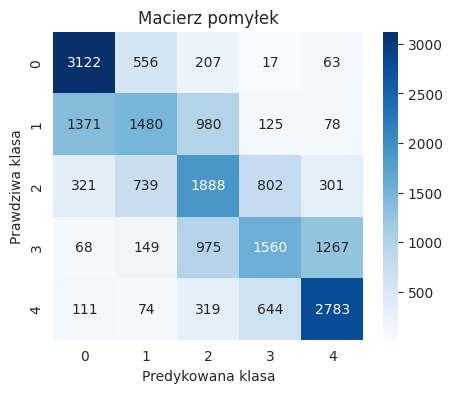

In [22]:
cm = confusion_matrix(targets, preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()